Ho separato le immagini perché se no serve una mappa per navigare quel file


Qui non commento tutto, Chiara io credo in te ce la puoi fare

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
from PIL import Image
# Load the JPEG image
import os
from skimage.filters.rank import mean as mean_filter
import csv
import pandas as pd

B = Image.open('sangue_rana/B.jpg')
B = np.array(B)
print(B.shape)

(1600, 1200, 3)


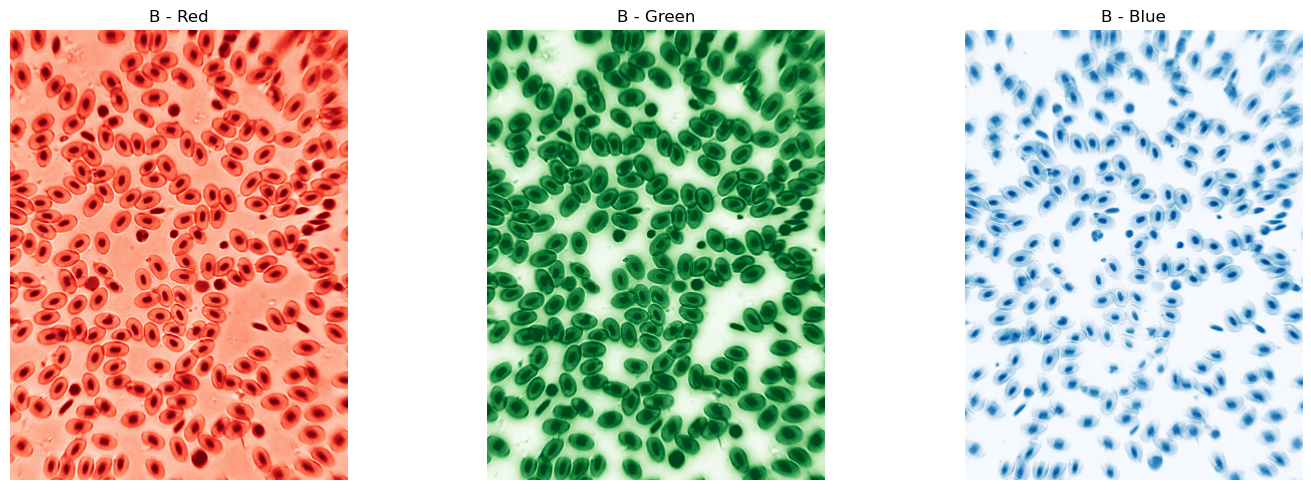

In [6]:
# Applica una convoluzione gaussiana (filtro) a ciascun canale dell'immagine B con sigma_B
sigma_B = 1

B_convolution = np.stack([ndi.gaussian_filter(B[:, :, ch], sigma_B) for ch in range(3)], axis=-1)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
channels = ['Red', 'Green', 'Blue']
cmaps = ['Reds_r', 'Greens_r', 'Blues_r']

for j in range(3):
    axs[j].imshow(B_convolution[:, :, j], cmap=cmaps[j])
    axs[j].set_title(f'B - {channels[j]}')
    axs[j].axis('off')

plt.tight_layout()
plt.show()


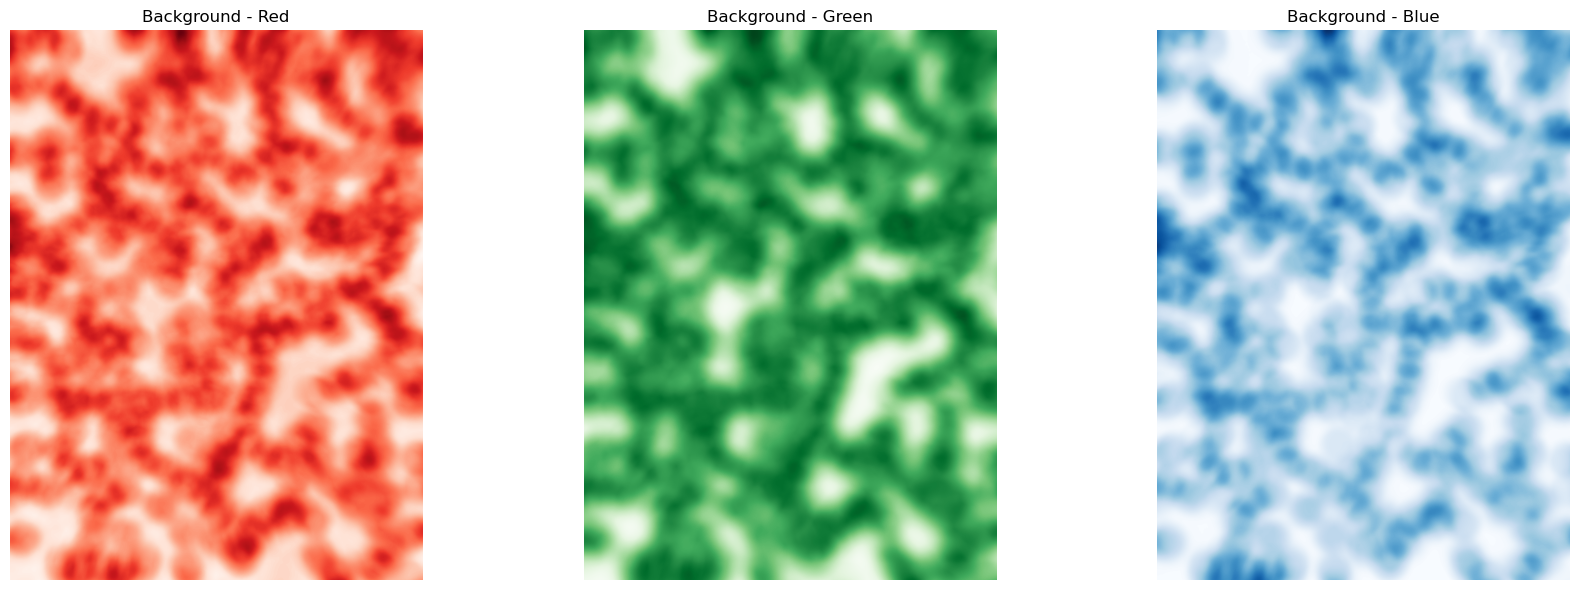

In [7]:
BKG_B_red = pd.read_csv('BKG_B_red.csv', header=None).to_numpy()
BKG_B_green = pd.read_csv('BKG_B_green.csv', header=None).to_numpy()
BKG_B_blue = pd.read_csv('BKG_B_blue.csv', header=None).to_numpy()

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
backgrounds = [BKG_B_red, BKG_B_green, BKG_B_blue]

for i, (bkg, channel, cmap) in enumerate(zip(backgrounds, channels, cmaps)):
    axs[i].imshow(bkg, cmap=cmap)
    axs[i].set_title(f'Background - {channel}')
    axs[i].axis('off')

plt.tight_layout()
plt.show()

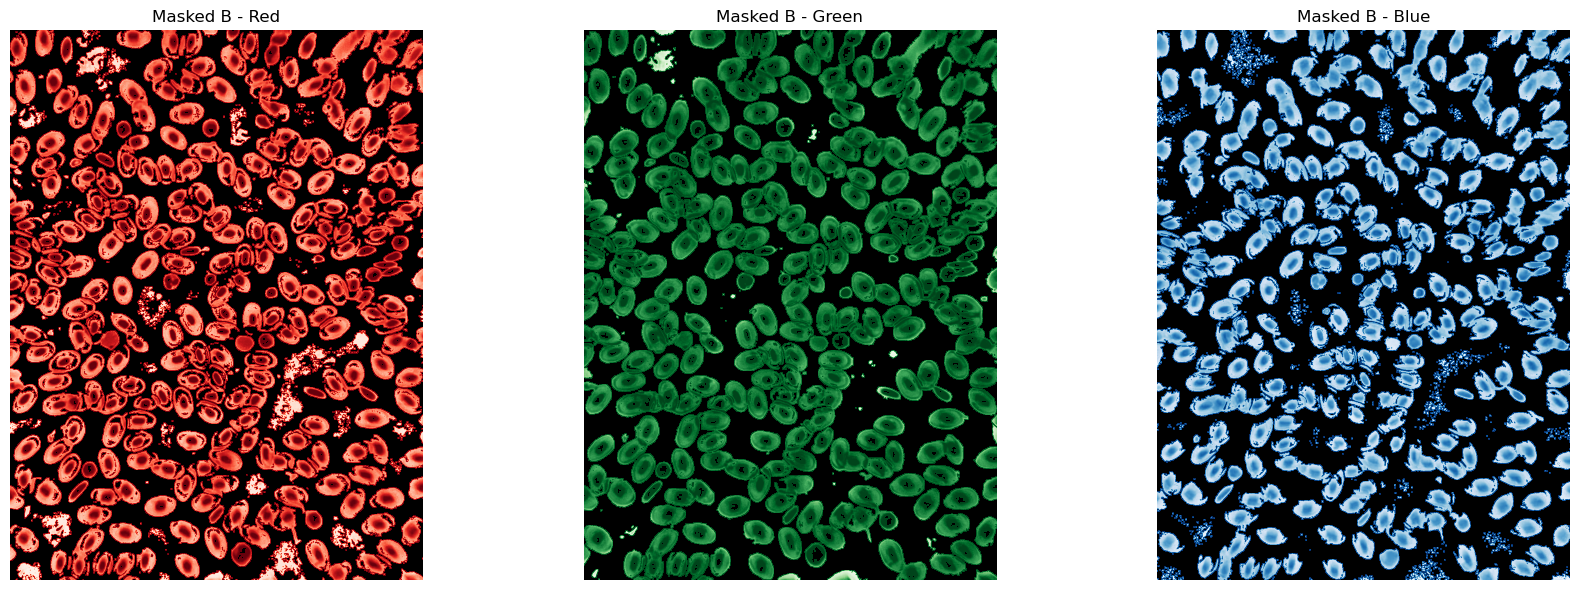

In [8]:
diff = B_convolution[:,:,0] < BKG_B_red
masked_B_red = np.where(diff, B_convolution[:,:,0], 0)

diff = B_convolution[:,:,1] < BKG_B_green
masked_B_green = np.where(diff, B_convolution[:,:,1], 0)

diff = B_convolution[:,:,2] < BKG_B_blue
masked_B_blue = np.where(diff, B_convolution[:,:,2], 0)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
masked_images = [masked_B_red, masked_B_green, masked_B_blue]
for i, (img, channel, cmap) in enumerate(zip(masked_images, channels, cmaps)):
    axs[i].imshow(img, cmap=cmap, vmin=0, vmax=img.max())
    axs[i].set_title(f'Masked B - {channel}')
    axs[i].axis('off')
    axs[i].imshow(np.ma.masked_where(img != 0, img), cmap='gray', vmin=0, vmax=1, alpha=1)  # overlay black for zeros
plt.tight_layout()
plt.show()

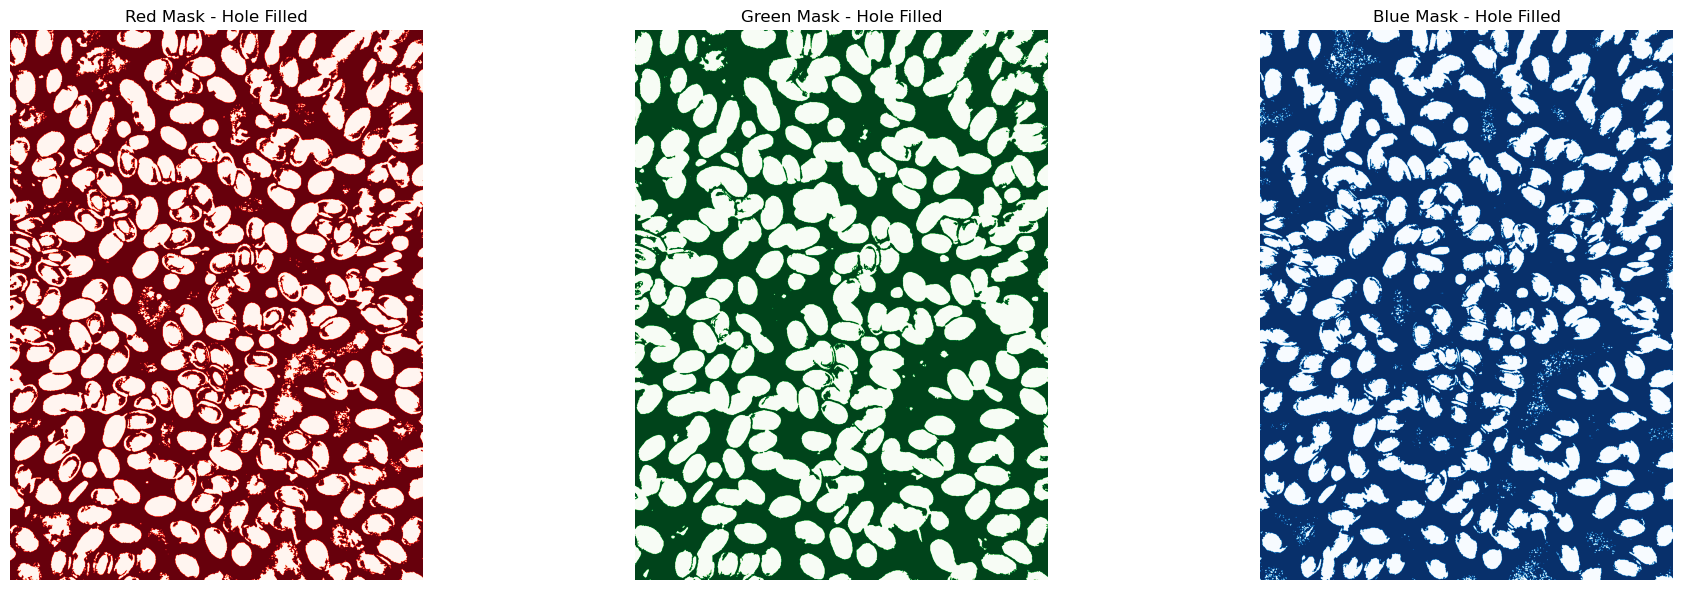

In [15]:
from scipy.ndimage import binary_fill_holes

B_red_filled = binary_fill_holes(masked_B_red, structure=np.ones((3, 3)))
B_green_filled = binary_fill_holes(masked_B_green, structure=np.ones((3, 3)))
B_blue_filled = binary_fill_holes(masked_B_blue, structure=np.ones((3, 3)))

fig, axs = plt.subplots(1, 3, figsize=(20, 6))

axs[0].imshow(B_red_filled, cmap='Reds_r')
axs[0].set_title('Red Mask - Hole Filled')
axs[0].axis('off')

axs[1].imshow(B_green_filled, cmap='Greens_r')
axs[1].set_title('Green Mask - Hole Filled')
axs[1].axis('off')

axs[2].imshow(B_blue_filled, cmap='Blues_r')
axs[2].set_title('Blue Mask - Hole Filled')
axs[2].axis('off')

plt.tight_layout()
plt.show()


tengo solo il verde


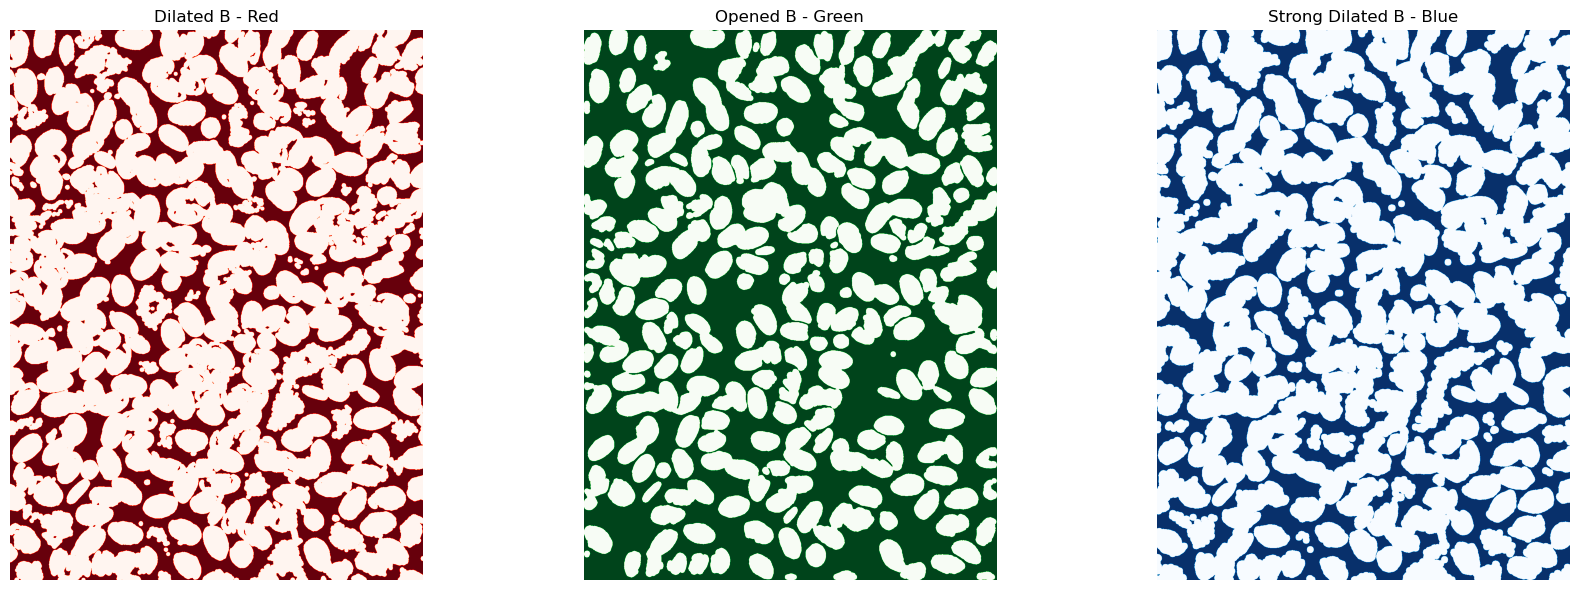

In [40]:
def circleSE(radius):
    """Create a circular structuring element with given radius."""
    L = np.arange(-radius, radius+1)
    X, Y = np.meshgrid(L, L)
    return (X**2 + Y**2) <= radius**2

# Rosso: solo dilatazione
masked_B_red_binary = B_red_filled > 0
B_red_dilated = ndi.binary_dilation(masked_B_red_binary, structure=circleSE(6))

# Verde: opening (erosione seguita da dilatazione)
masked_B_green_binary = B_green_filled > 0
B_green_dilated = ndi.binary_opening(masked_B_green_binary, structure=circleSE(8))

# Blu: dilatazione più importante
masked_B_blue_binary = B_blue_filled > 0
B_blue_dilated = ndi.binary_dilation(masked_B_blue_binary, structure=circleSE(10))

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].imshow(B_red_dilated, cmap='Reds_r')
axs[0].set_title('Dilated B - Red')
axs[0].axis('off')

axs[1].imshow(B_green_dilated, cmap='Greens_r')
axs[1].set_title('Opened B - Green')
axs[1].axis('off')

axs[2].imshow(B_blue_dilated, cmap='Blues_r')
axs[2].set_title('Strong Dilated B - Blue')
axs[2].axis('off')

plt.tight_layout()
plt.show()


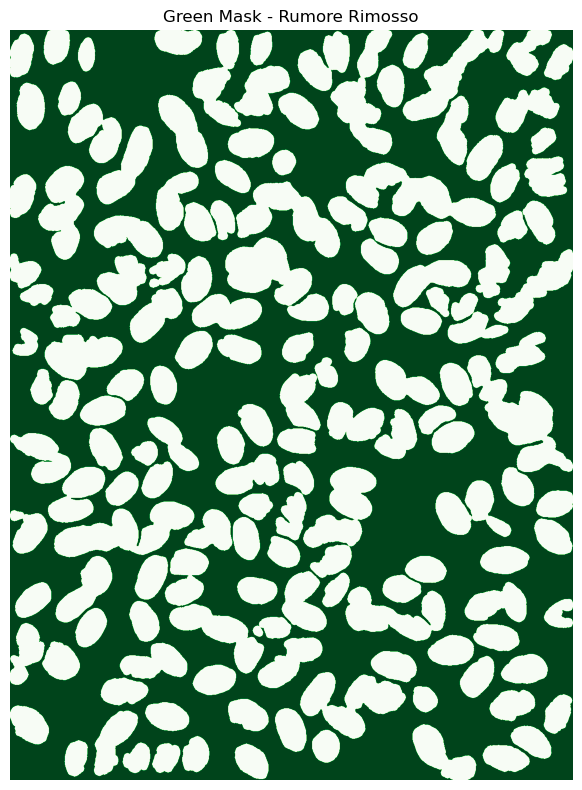

In [44]:
from skimage.morphology import remove_small_objects

# Imposta la dimensione minima per il canale verde
min_size_g = 2000

B_green_cleaned = remove_small_objects(B_green_dilated, min_size=min_size_g)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(B_green_cleaned, cmap='Greens_r')
ax.set_title('Green Mask - Rumore Rimosso')
ax.axis('off')
plt.tight_layout()
plt.show()


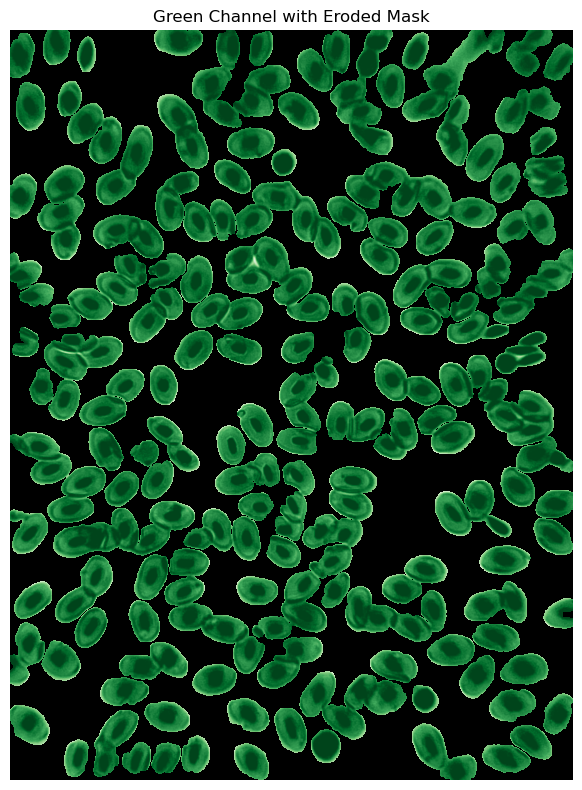

In [45]:
B_green_cleaned_nan = np.where(B_green_cleaned, np.nan, 0)

plt.figure(figsize=(8, 8))
plt.imshow(B_convolution[:, :, 1], cmap='Greens_r')
plt.imshow(B_green_cleaned_nan, cmap='gray', alpha=1)
plt.title('Green Channel with Eroded Mask')
plt.axis('off')
plt.tight_layout()
plt.show()


Number of green objects: 154


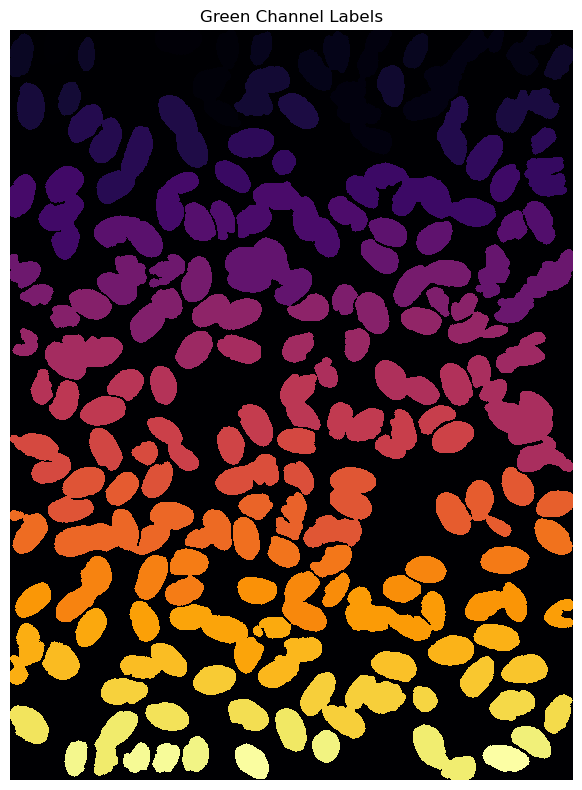

In [47]:
# Label connected components for green mask only
green_labels, num_green = ndi.label(B_green_cleaned)
print(f'Number of green objects: {num_green}')

plt.figure(figsize=(8, 8))
plt.imshow(green_labels, cmap='inferno', interpolation='none')
plt.title('Green Channel Labels')
plt.axis('off')
plt.tight_layout()
plt.show()


ahi ahi ahi per ilverde dovremo watersheddare un sacco


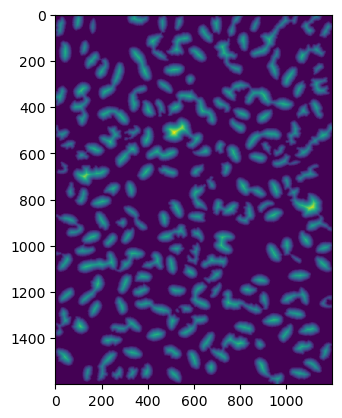

In [48]:
dist_trans = ndi.distance_transform_edt(B_green_cleaned)
plt.figure()
plt.imshow(dist_trans,interpolation='none',cmap='viridis')
plt.show()

/tmp/ipykernel_18527/3790133149.py:6: DeprecationWarning: Please use `maximum_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  dist_trans_dil = ndi.filters.maximum_filter(dist_trans, footprint=struct)


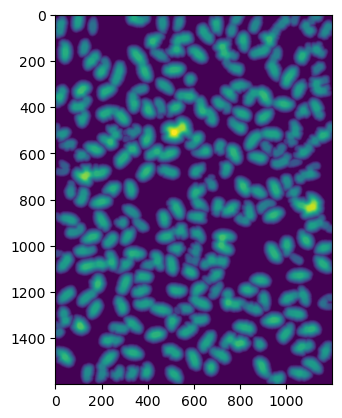

In [69]:
i = 20
mgrid = np.mgrid[:i,:i]
struct = (mgrid[0] - np.floor(i/2))**2 + (mgrid[1] - np.floor(i/2))**2 <= np.floor(i/2)**2

# Running the dilation
dist_trans_dil = ndi.filters.maximum_filter(dist_trans, footprint=struct) 

# Visualizing again
plt.figure()
plt.imshow(dist_trans_dil, cmap='viridis')
plt.show()

tripofobia portami via

In [87]:
seedLoc = peak_local_max(
    dist_trans_dil,
    min_distance=40,
    labels=B_green_cleaned,
    threshold_abs=2,  # adjust as needed
    exclude_border=10
)
seeds = np.zeros_like(dist_trans_dil, dtype=bool)
seeds[tuple(seedLoc.T)] = True

print(f'Number of seeds: {len(seedLoc)}')



Number of seeds: 197


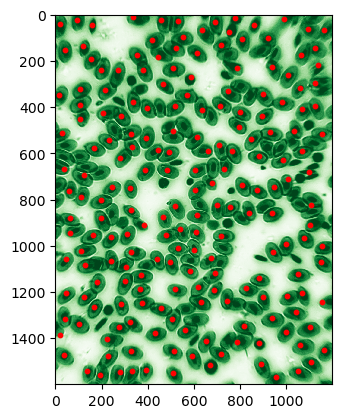

In [88]:
plt.figure()
plt.imshow(B_convolution[:, :, 1], cmap='Greens_r', interpolation='none')

y, x = np.where(seeds)
plt.scatter(x, y, c='red', s=10, marker='o')
plt.show()

seeds_labeled = ndi.label(seeds)[0]

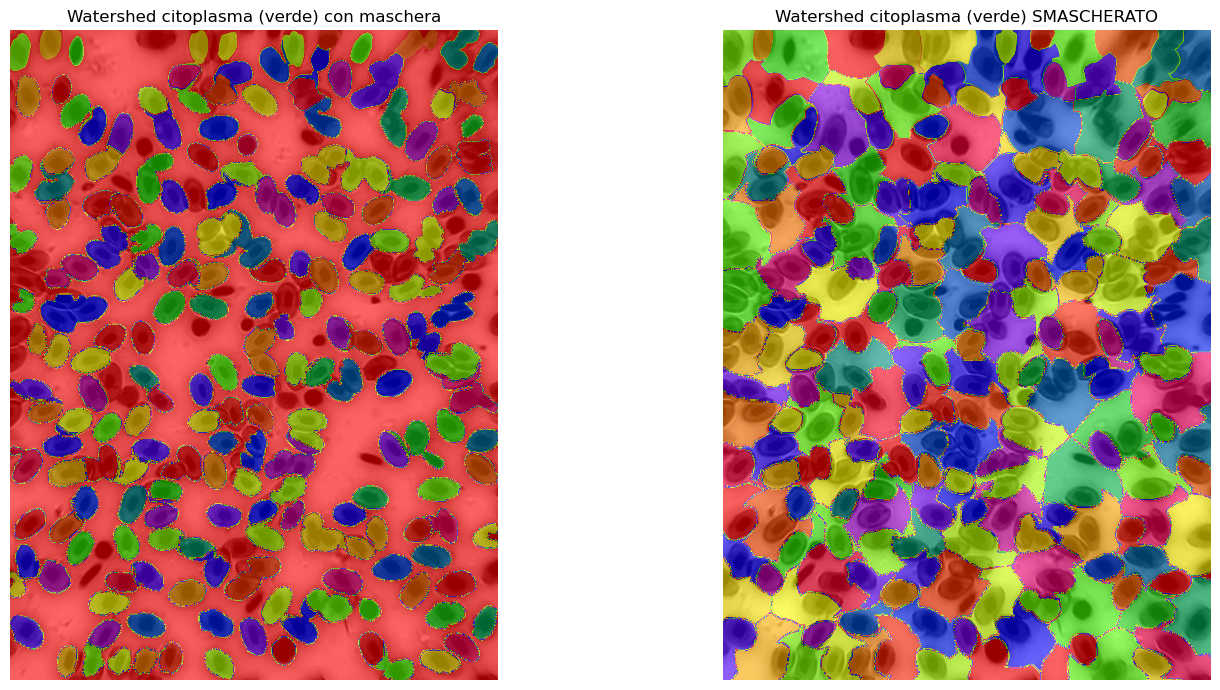

In [90]:
from skimage.segmentation import watershed

# Watershed su verde con maschera
ws_green = watershed(dist_trans_dil, seeds_labeled, connectivity=1, compactness=0.3,
                    watershed_line=True, mask=B_green_cleaned)

# Watershed su verde SENZA maschera
ws_green_nomask = watershed(dist_trans_dil, seeds_labeled, connectivity=1, compactness=0.3,
                           watershed_line=True, mask=None)

# Visualizzazione affiancata con cmap categoriale
fig, axs = plt.subplots(1, 2, figsize=(16, 7))

axs[0].imshow(B_convolution[:, :, 1], cmap='gray')
axs[0].imshow(ws_green, cmap='prism', alpha=0.6)
axs[0].set_title('Watershed citoplasma (verde) con maschera')
axs[0].axis('off')

axs[1].imshow(B_convolution[:, :, 1], cmap='gray')
axs[1].imshow(ws_green_nomask, cmap='prism', alpha=0.6)
axs[1].set_title('Watershed citoplasma (verde) SMASCHERATO')
axs[1].axis('off')

plt.tight_layout()
plt.show()


Se sapete fare di meglio divertitevi


In [93]:
boundary_mask = np.ones(ws_green.shape, dtype=bool)
boundary_mask = np.logical_not(ndi.binary_erosion(boundary_mask, iterations=15, border_value=0))
clean_ws = np.copy(ws_green)

In [95]:
def remove_border_cells(label_img, boundary_mask):
    # Copia per non modificare l'input originale
    cleaned = np.copy(label_img)
    for cell_ID in np.unique(cleaned):
        if cell_ID == 0:
            continue
        cell_mask = cleaned == cell_ID
        if np.any(np.logical_and(cell_mask, boundary_mask)):
            cleaned[cell_mask] = 0
    # Rietichetta da 1 a N
    for new_ID, cell_ID in enumerate(np.unique(cleaned)[1:]):
        cleaned[cleaned == cell_ID] = new_ID + 1
    return cleaned

clean_ws = remove_border_cells(ws_green, boundary_mask)
clean_ws_b = remove_border_cells(ws_green_nomask, boundary_mask)


<Figure size 640x480 with 0 Axes>

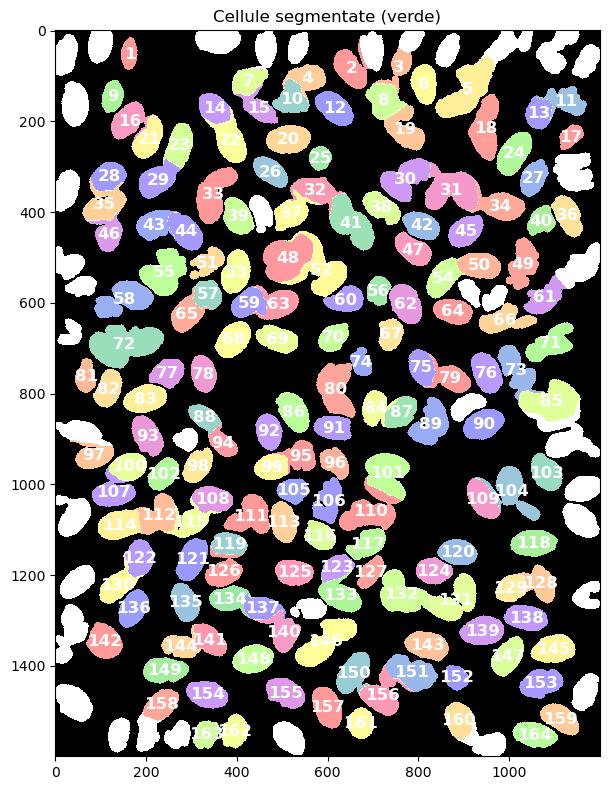

In [98]:
plt.figure()
fig, ax = plt.subplots(1, 1, figsize=(9, 8))

# Verde (citoplasma)
ax.imshow(B_green_cleaned, interpolation='none', cmap='gray')
ax.imshow(np.ma.array(clean_ws, mask=clean_ws == 0), interpolation='none', cmap='prism', alpha=0.4)
for cell_id in np.unique(clean_ws):
    if cell_id == 0:
        continue
    ys, xs = np.where(clean_ws == cell_id)
    if len(xs) > 0 and len(ys) > 0:
        y_c, x_c = np.mean(ys), np.mean(xs)
        ax.text(x_c, y_c, str(cell_id), color='white', fontsize=12, ha='center', va='center', weight='bold')
ax.set_title("Cellule segmentate (verde)")

plt.tight_layout()
plt.show()


In [100]:
# Crea la versione "pulita" per i nuclei blu senza outlier
# clean_ws_b = clean_ws_b_no_outliers

# Calcola i bordi per i nuclei blu
edges_blue = np.zeros_like(clean_ws_b)
for cell_ID in np.unique(clean_ws_b)[1:]:
    cell_mask = clean_ws_b == cell_ID
    eroded_cell_mask = ndi.binary_erosion(cell_mask, iterations=1)
    edge_mask = np.logical_xor(cell_mask, eroded_cell_mask)
    edges_blue[edge_mask] = cell_ID

# Calcola i bordi per le cellule verdi
edges = np.zeros_like(clean_ws)
for cell_ID in np.unique(clean_ws)[1:]:
    cell_mask = clean_ws == cell_ID
    eroded_cell_mask = ndi.binary_erosion(cell_mask, iterations=1)
    edge_mask = np.logical_xor(cell_mask, eroded_cell_mask)
    edges[edge_mask] = cell_ID


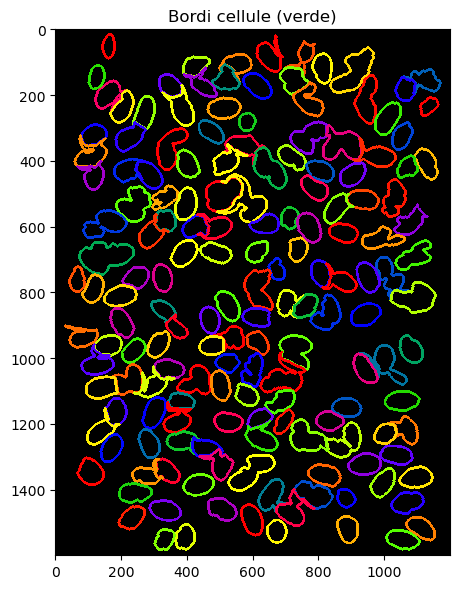

In [102]:
from scipy.ndimage import binary_dilation

# Dilatazione per rendere i bordi più spessi (fattore 2, puoi aumentare iterations per bordi ancora più spessi)
edges_thick = np.zeros_like(edges)
for cell_ID in np.unique(edges)[1:]:
    edge_mask = edges == cell_ID
    thick_mask = binary_dilation(edge_mask, iterations=4)
    edges_thick[thick_mask] = cell_ID

plt.figure(figsize=(15, 6))

# Bordi cellule (verde)
plt.subplot(1, 2, 1)
plt.imshow(np.zeros_like(edges), cmap='gray', vmin=0, vmax=1)  # Black background
plt.imshow(np.ma.array(edges_thick, mask=edges_thick == 0), interpolation='none', cmap='prism')
plt.title('Bordi cellule (verde)')


plt.tight_layout()
plt.show()

In [103]:
results = {"cell_id": [],
           "green_mean": [],
           "green_mem_mean": [],
           "cell_area": [],
           "cell_edge": []}

for cell_id in np.unique(clean_ws)[1:]:
    cell_mask = clean_ws == cell_id
    edge_mask = edges == cell_id

    results["cell_id"].append(cell_id.item())
    results["green_mean"].append(np.mean(B_convolution[:, :, 1][cell_mask]).item())
    results["green_mem_mean"].append(np.mean(B_convolution[:, :, 1][edge_mask]).item())
    results["cell_area"].append(np.sum(cell_mask).item())
    results["cell_edge"].append(np.sum(edge_mask).item())

for key in results.keys():
    print(key, '\n', results[key], '\n')


cell_id 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164] 

green_mean 
 [41.26814814814815, 33.84381640458989, 16.32597864768683, 30.764319495533368, 38.64358070909491, 36.36779619094732, 33.13735485698103, 29.65101387406617, 34.236363636363635, 27.8182525278714, 35.03522699082114, 39.53412593571114, 41.18859245630175, 42.6220043572

In [105]:
def print_summary(data):
    data = np.array(data)
    data = data[~np.isnan(data)]  # rimuove i nan
    if len(data) == 0:
        print("  Nessun dato valido.")
        return
    print ("  Mean:    {:7.2f}".format(np.mean(data)))
    print ("  Stdev:   {:7.2f}".format(np.std(data)))
    print ("  Max:     {:7.2f}".format(np.max(data)))
    print ("  Min:     {:7.2f}".format(np.min(data)))
    print ("  Median:  {:7.2f}".format(np.median(data)))

# Stampa il riepilogo per ogni chiave in results
for key in results.keys():
    print('\n' + key)
    print_summary(results[key])

from scipy.stats import describe
data = np.array(results['green_mean'])
data = data[~np.isnan(data)]
stat_summary = describe(data)

print('\nscipy.stats.describe of green_mean')
for key, value in stat_summary._asdict().items():
    print(' ', key, value)


cell_id
  Mean:      82.50
  Stdev:     47.34
  Max:      164.00
  Min:        1.00
  Median:    82.50

green_mean
  Mean:      39.23
  Stdev:      6.87
  Max:       59.62
  Min:       16.33
  Median:    38.89

green_mem_mean
  Mean:      72.87
  Stdev:     16.08
  Max:      117.82
  Min:       40.20
  Median:    70.91

cell_area
  Mean:    4430.96
  Stdev:   1365.42
  Max:     10858.00
  Min:     2025.00
  Median:  4200.50

cell_edge
  Mean:     259.97
  Stdev:     75.37
  Max:      609.00
  Min:      147.00
  Median:   230.50

scipy.stats.describe of green_mean
  nobs 164
  minmax (16.32597864768683, 59.62125340599455)
  mean 39.23163524526918
  variance 47.45481359706917
  skewness -0.18513702863846204
  kurtosis 0.7641949471340035


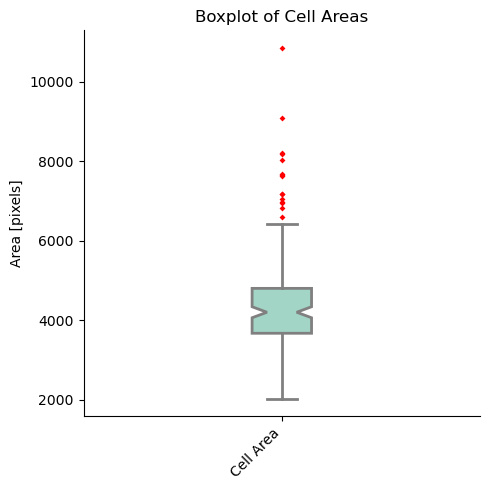

In [108]:
# Visualizza solo la cell_area
area_keys = ['cell_area']
area_data = [np.array(results[key])[~np.isnan(results[key])] for key in area_keys]

fig = plt.figure(figsize=(5, 5))
ax = fig.gca()

bplot = ax.boxplot(area_data, notch=True, patch_artist=True)

area_colors = ['#a2d5c6']
for patch, color in zip(bplot['boxes'], area_colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('gray')
    patch.set_linewidth(2)

plt.setp(bplot['whiskers'], color='gray', linestyle='-', lw=2)
plt.setp(bplot['caps'], color='gray', lw=2)
plt.setp(bplot['medians'], linestyle='none')
plt.setp(bplot['fliers'], marker='D', markerfacecolor='red',
         markeredgewidth=0, markersize=3)

ax.set_xticklabels(['Cell Area'], rotation=45, ha='right')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_title('Boxplot of Cell Areas')
ax.set_ylabel('Area [pixels]')

plt.tight_layout()
plt.show()
